# Pokemon GAN Training Notebook

**Import libraries**

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from dataset import PokemonGensDataset
from WACGAN import WACGAN
from utils import show_tensor_images
import variable as var
import os

**Load labels**

In [2]:
resume_training = False
train_number = 1
gan_id = f"wacgan_pokemon_train_{train_number}"

greyscale = False
resize_image_dim = 64
n_conv_block = 3
batch_size = 128
print(f"Greyscale: {greyscale}")
print(f"Real: {resize_image_dim}x{resize_image_dim} images")
print(f"Fake: {2**(3 + n_conv_block)}x{2**(3 + n_conv_block)} images")

Greyscale: False
Real: 64x64 images
Fake: 64x64 images


In [3]:
dset = PokemonDataset(greyscale, resize=[resize_image_dim, resize_image_dim], 
                      shiny=False, frame2=True)
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=0)

dloader = DataLoader(
    MNIST(os.environ['DATASETS'], 
          download=False, 
          transform=transforms.Compose([transforms.ToTensor(), 
                                        transforms.Resize([resize_image_dim, resize_image_dim])
                                       ])
         ), 
    batch_size=batch_size,
    shuffle=True)

In [4]:
len(dloader)*batch_size

896

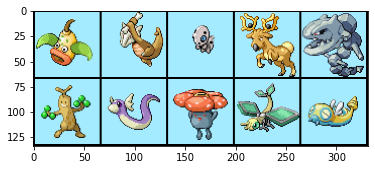

tensor([ 0,  7, 16,  4, 16, 11, 14,  0,  7,  4, 10,  0, 10, 15,  4,  9,  4, 16,
         4,  5,  2,  4,  6, 10,  1, 15,  2,  3, 10,  0, 11, 11, 14, 10,  4,  4,
        10, 15,  4,  2,  7,  1, 10,  2,  3,  5, 10,  2, 11, 11,  0,  2, 12,  0,
         2,  2,  5, 10,  4, 16,  4,  4,  4,  4,  4,  4,  1, 11,  4,  4,  1,  4,
         2,  2,  3,  2, 15,  1, 11,  4,  5,  2, 13,  4,  5,  3,  2, 11,  9,  2,
         1,  4,  7,  9,  4, 11,  4,  1,  5,  0,  1, 10,  2,  2,  2,  2,  5,  5,
         4, 15,  2, 10,  5,  3, 10,  2,  9,  4,  4, 14,  2,  9, 14,  2, 10,  2,
        15, 16])

In [5]:
images, labels = next(iter(dloader))
show_tensor_images(images)
labels

**GAN Component**

In [6]:
betas = (.5, .999)
n_channel = 1 if greyscale else 3
n_feature = 128
z_dim = 100
n_classes = len(dset.label_map)
    
params = {'gen': {'n_feature': n_feature,
                  'n_channel': n_channel,
                  'lr': 5e-4,
                  'betas': betas},
          'critic': {'n_channel': n_channel,
                   'n_feature': n_feature,
                   'lr': 5e-4,
                   'betas': betas},
          'z_dim': z_dim,
          'n_conv_block': n_conv_block,
          'n_classes': n_classes,
          'gradient_penalty_factor': 2,
          'stability_noise_std': 5e-2
         }

In [7]:
gan = WACGAN(params)
if os.path.exists(f'data/models/{gan_id}.pth'):
    print('RESUMING TRAINING...')
    gan.load_model(f'data/models/{gan_id}.pth')
else:
    print('NEW TRAINING...')

NEW TRAINING...


In [8]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [10]:
gan.train(n_epoch=50, dataloader=dloader, gan_id=gan_id)

100%|██████████| 50/50 [03:54<00:00,  4.70s/it]


**RESULT**

In [245]:
str(dset.label_map)

"{0: 'grass', 1: 'fire', 2: 'water', 3: 'bug', 4: 'normal', 5: 'poison', 6: 'electric', 7: 'ground', 8: 'fairy', 9: 'fighting', 10: 'psychic', 11: 'rock', 12: 'ghost', 13: 'ice', 14: 'dragon', 15: 'dark', 16: 'steel'}"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class: fairy


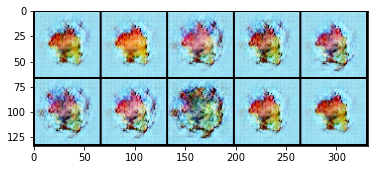

In [287]:
being_class = 8
print(f"class: {dset.label_map[being_class]}")
fakes, classes = gan.generate_fake(10, train=False, being_class=being_class)


show_tensor_images(fakes)

In [114]:
for i_batch, (real, real_classes) in enumerate(dloader):
    real = real.to(var.device)
    real_classes = real_classes.to(var.device)
    with torch.no_grad():
        _, real_aux = gan.discriminator(real)
    labels = torch.argmax(real_aux, dim=1)
    print((labels == real_classes).sum()/len(real_classes))

tensor(0.9844, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9609, device='cuda:0')
tensor(0.9844, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9844, device='cuda:0')
tensor(0.9766, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9412, device='cuda:0')


In [103]:
_, real_aux = gan.discriminator(images.to(var.device))

In [112]:
labels

tensor([10, 10,  4,  7,  0, 11, 10,  6, 10, 13,  6,  3, 14, 13,  6,  4,  6,  2,
         6, 13,  4, 14,  2,  3, 10,  2, 11,  0,  2,  0,  0, 16,  4, 10,  2,  4,
         1,  9,  7,  1,  0,  4,  4,  5,  2, 13,  2,  1,  2, 10, 16,  2,  4, 15,
         3,  2,  4,  0, 14,  4, 10,  7,  1,  3,  3,  7, 11,  5,  3, 16,  3,  3,
        14,  3,  4,  2,  3,  1,  7,  6,  0,  2,  5,  3,  6,  3,  2,  4,  0,  5,
         0,  5,  3,  2, 10, 13, 11,  9, 16, 14,  2,  5,  0,  1,  4,  3, 16, 10,
        10,  5,  1,  6,  3, 14, 14,  0, 10,  6, 10, 15,  0, 10,  2,  4, 14,  2,
         7,  4])

In [15]:
(torch.ones((4, )).long() * 5).dtype

torch.int64

In [57]:
torch.randn(3) * 0.1

tensor([-0.2394, -0.1888,  0.2054])